# Random Graphs Impact Analysis

This notebook analyzes the impact of removing the highest-degree node from different types of random graphs on various centrality metrics.

In [1]:
# SETUP: workaround to avoid import errors
import os
import sys

candidate_roots = [
    os.getcwd(),
    os.path.dirname(os.getcwd()),
    os.path.dirname(os.path.dirname(os.getcwd())),
]
for root in candidate_roots:
    src_dir = os.path.join(root, "src")
    if os.path.isdir(src_dir) and src_dir not in sys.path:
        sys.path.append(src_dir)
        break

In [2]:
import networkx as nx

# define centrality metrics for the analysis
centrality_functions = {
    "degree": nx.degree_centrality,
    "betweenness": nx.betweenness_centrality,
    "closeness": nx.closeness_centrality,
    "eigenvector": lambda G: nx.eigenvector_centrality(G, max_iter=5000),
    # Use numpy variant for stability on larger graphs
    "katz": lambda G: nx.katz_centrality_numpy(G, alpha=0.01, beta=1.0),
}

# define graph sizes
sizes = [10, 100]

# define graph types
graph_types = [
    "erdos_renyi", 
    "barabasi_albert", 
    "watts_strogatz"
]

In [3]:
from graph_build_utlis import make_graph, highest_degree_node
from node_removal_graph_analyser import get_node_removal_impact

# compute the differences in centrality
results = []
for size in sizes:
    for gtype in graph_types:
        G = make_graph(gtype, size)
        node = highest_degree_node(G)

        for metric_name, metric_fn in centrality_functions.items():
            elapsed, impact = get_node_removal_impact(G, node, metric_fn)
            results.append({
                "size": size,
                "graph_type": gtype,
                "metric": metric_name,
                "impact": impact,
                "graph": G
            })


{0: 0.5555555555555556, 1: 0.5555555555555556, 2: 0.5555555555555556, 3: 0.5555555555555556, 4: 0.2222222222222222, 5: 0.3333333333333333, 6: 0.3333333333333333, 7: 0.3333333333333333, 8: 0.4444444444444444, 9: 0.7777777777777777}
{0: 0.5, 1: 0.5, 2: 0.5, 3: 0.625, 4: 0.125, 5: 0.375, 6: 0.25, 7: 0.25, 8: 0.375}
{0: 0.09953703703703703, 1: 0.0648148148148148, 2: 0.09259259259259257, 3: 0.12268518518518519, 4: 0.0, 5: 0.009259259259259259, 6: 0.006944444444444444, 7: 0.020833333333333332, 8: 0.023148148148148143, 9: 0.2546296296296296}
{0: 0.29166666666666663, 1: 0.07738095238095237, 2: 0.15476190476190474, 3: 0.32738095238095233, 4: 0.0, 5: 0.011904761904761904, 6: 0.0, 7: 0.029761904761904757, 8: 0.07142857142857142}
{0: 0.6923076923076923, 1: 0.6923076923076923, 2: 0.6923076923076923, 3: 0.6923076923076923, 4: 0.5294117647058824, 5: 0.5625, 6: 0.6, 7: 0.6, 8: 0.6428571428571429, 9: 0.8181818181818182}
{0: 0.6666666666666666, 1: 0.6153846153846154, 2: 0.6666666666666666, 3: 0.72727272

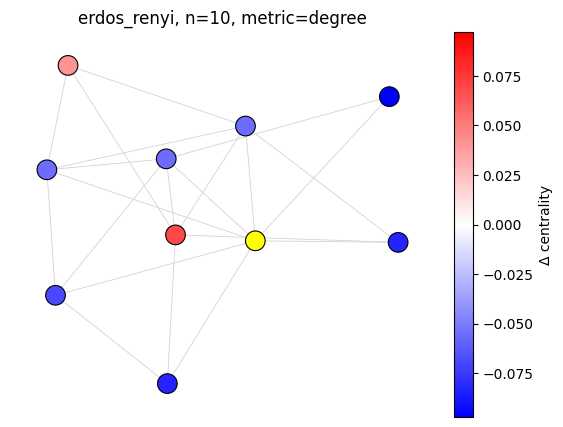

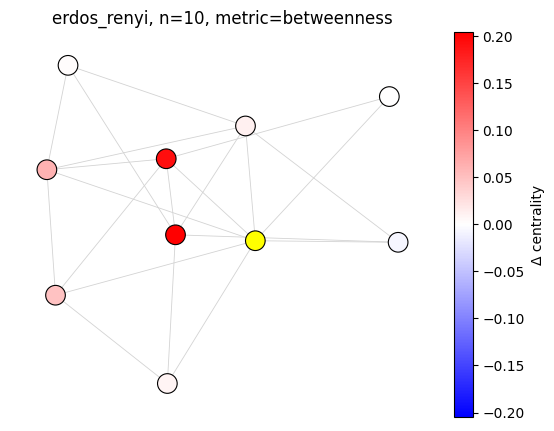

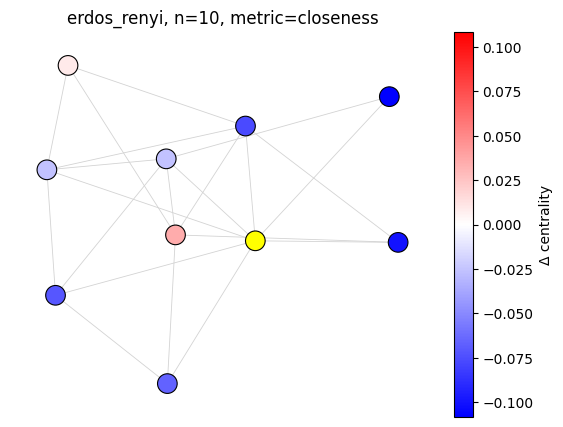

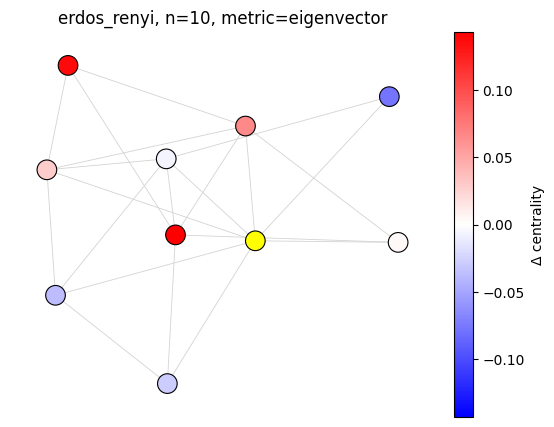

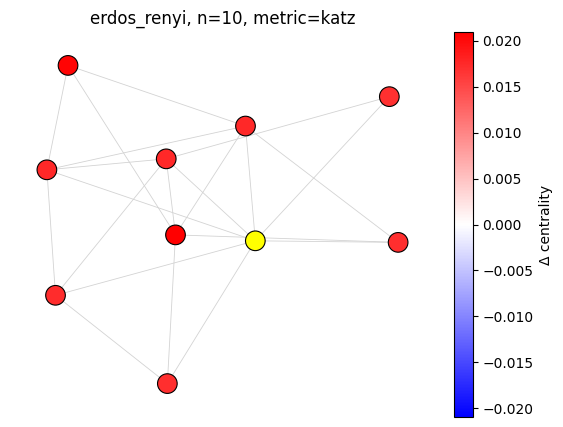

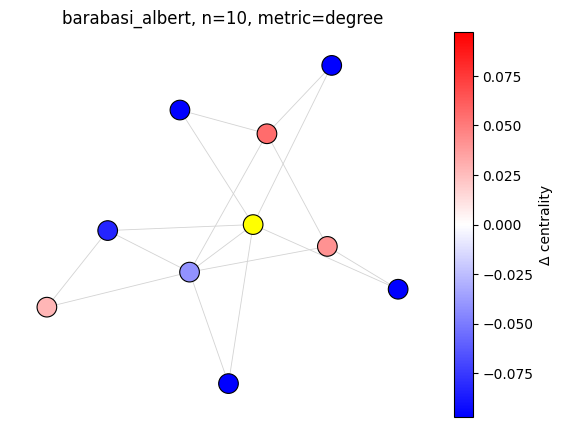

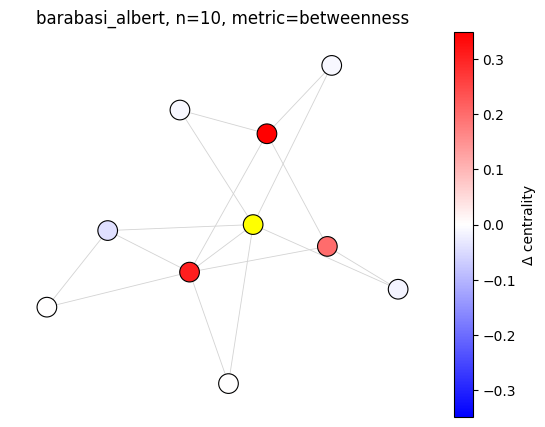

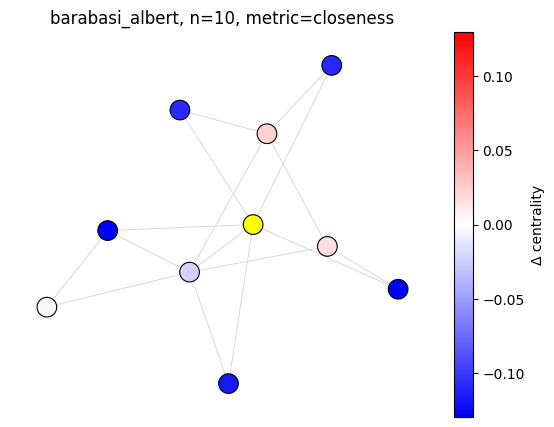

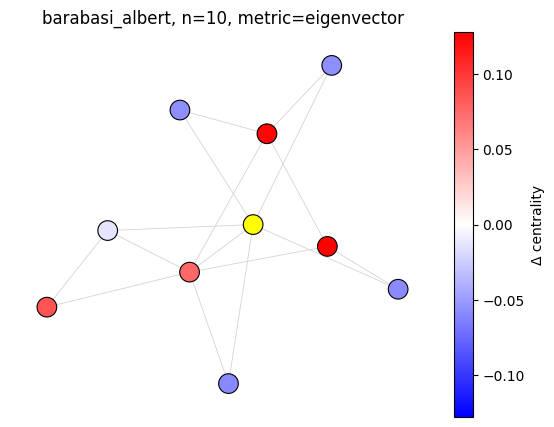

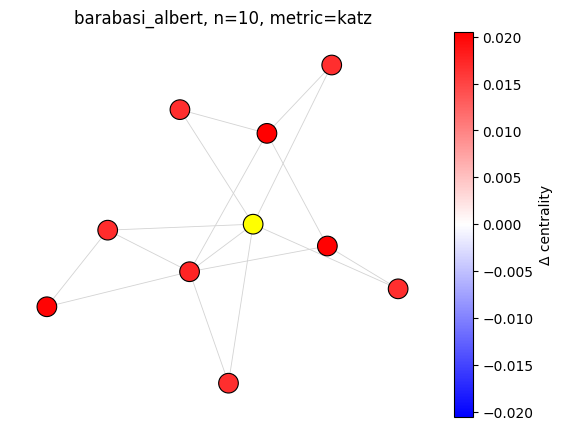

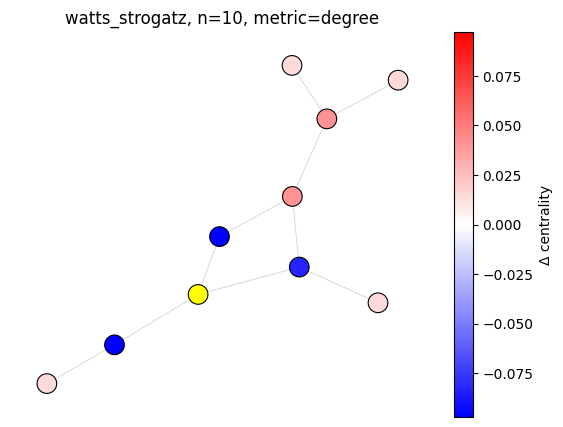

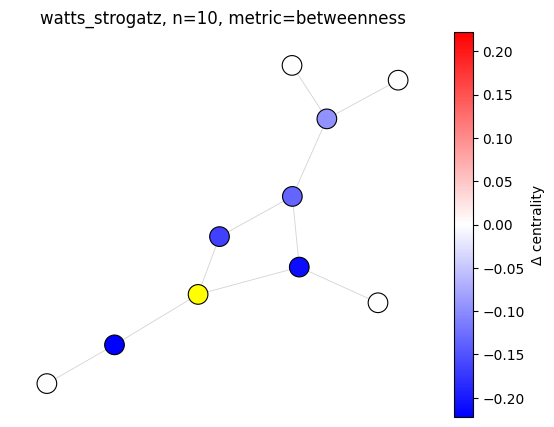

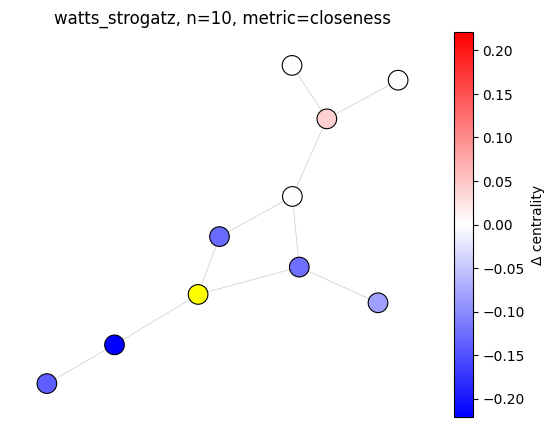

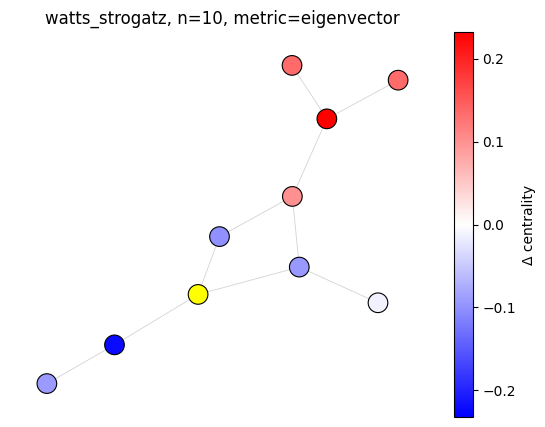

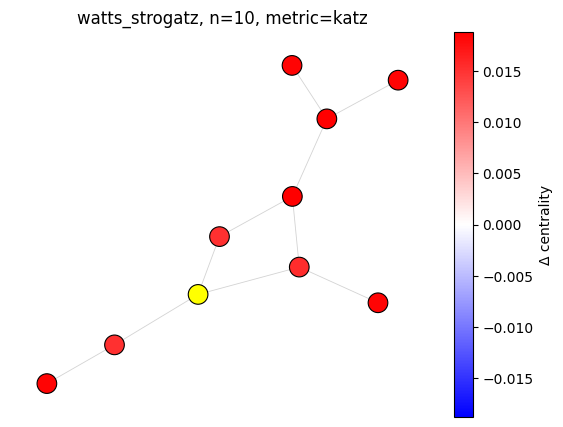

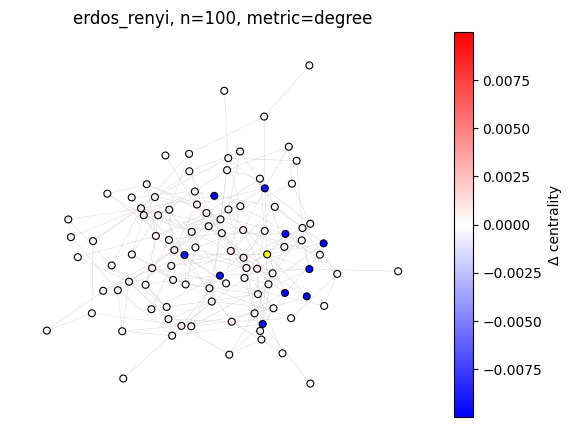

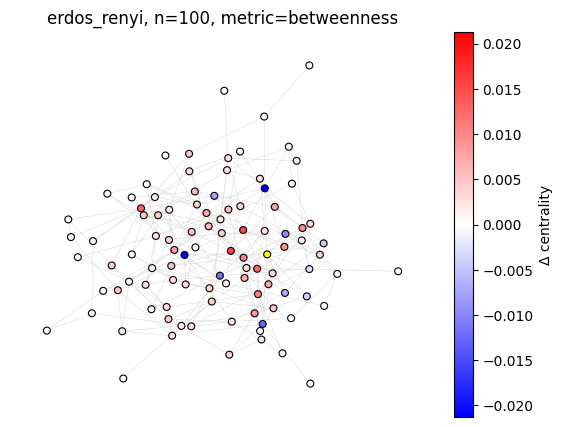

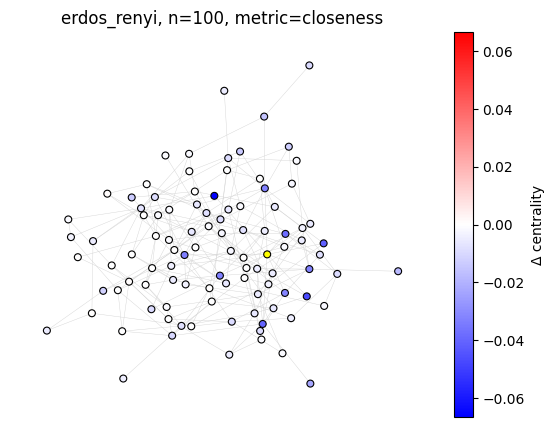

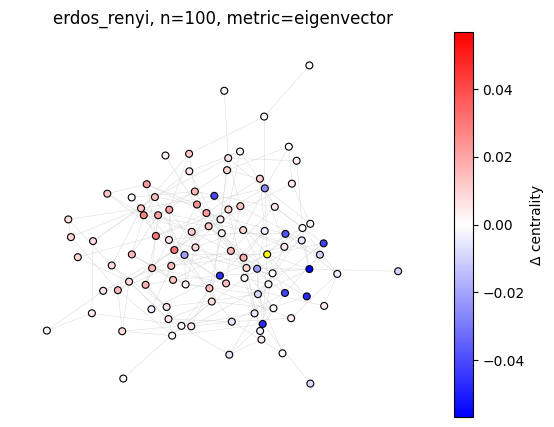

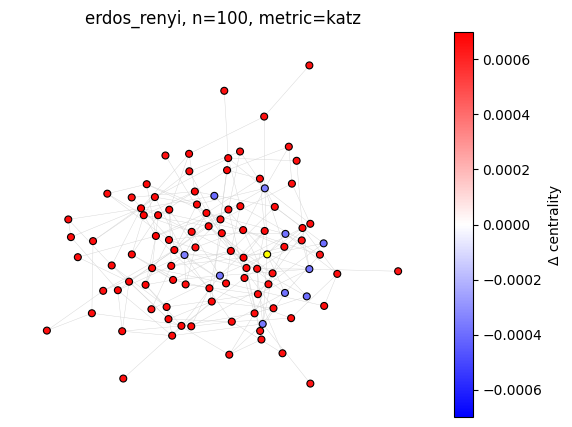

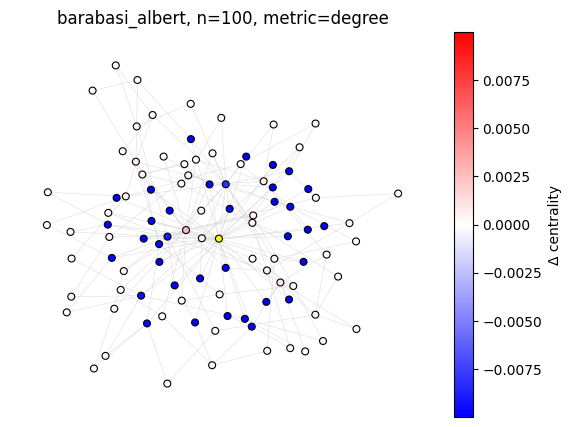

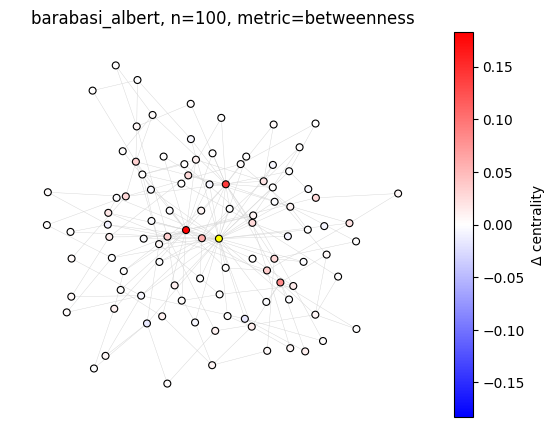

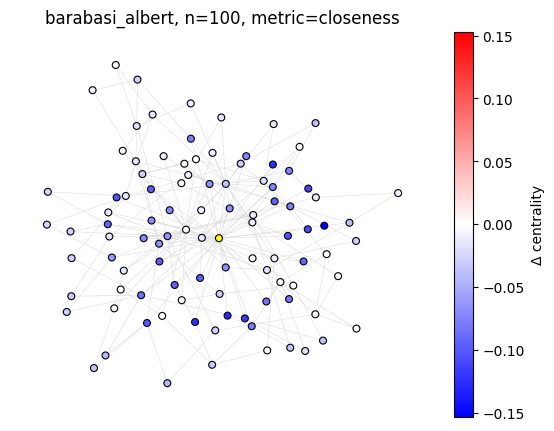

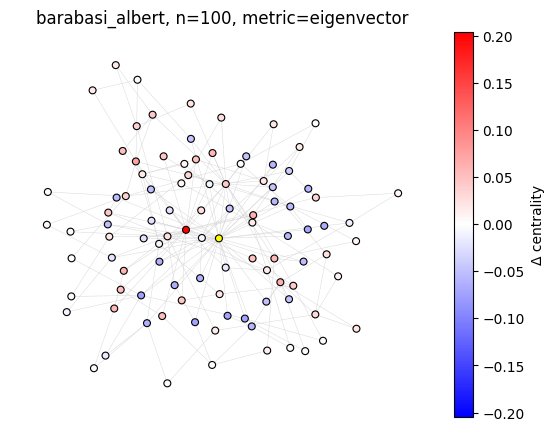

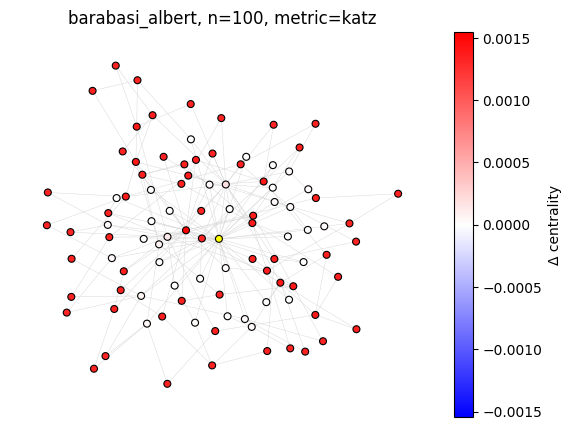

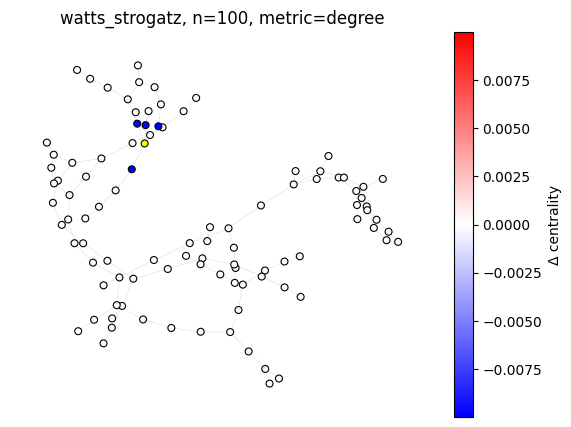

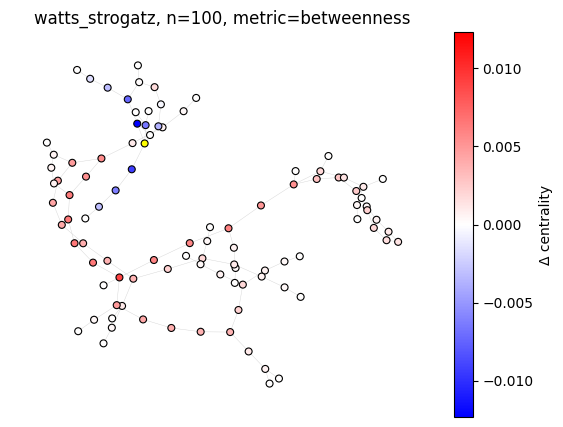

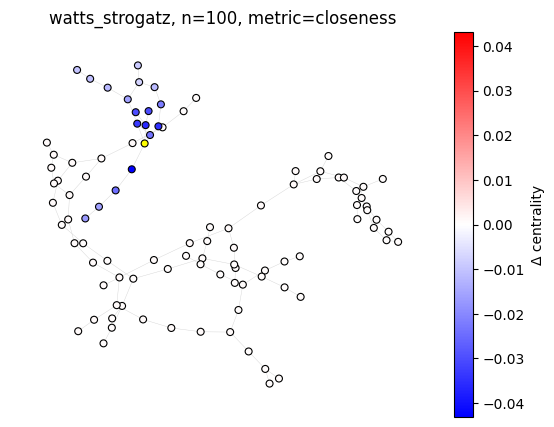

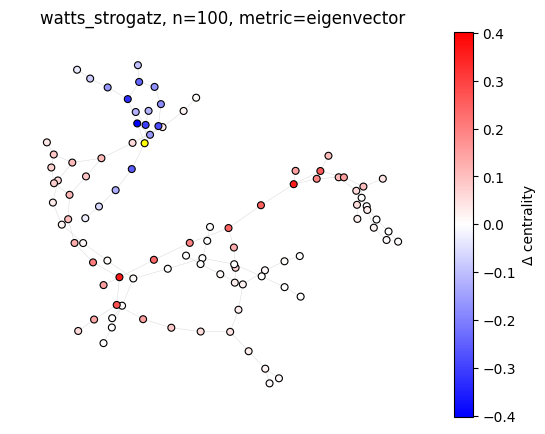

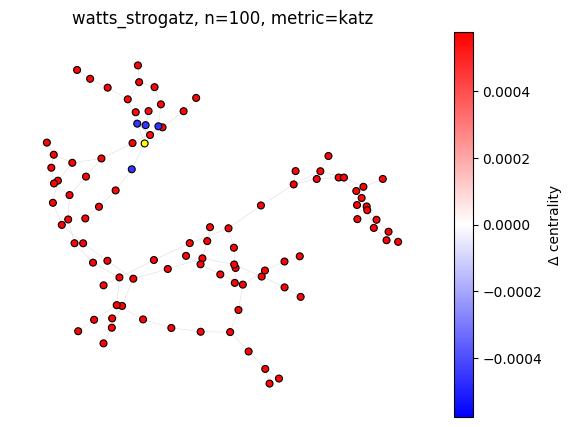

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, colors

pos_cache = {}

for r in results:
    size = r["size"]
    gtype = r["graph_type"]
    metric = r["metric"]
    impact = r["impact"]
    G = r["graph"]
    
    removed_node = highest_degree_node(G)

    # Layout cache per (graph_type, size)
    key = (gtype, size)
    if key not in pos_cache:
        if size >= 500:
            pos_cache[key] = nx.spring_layout(G, seed=42, k=1 / np.sqrt(size), iterations=50)
        else:
            pos_cache[key] = nx.spring_layout(G, seed=42)
    pos = pos_cache[key]

    # Normalize impacts for color mapping
    max_abs = max((abs(v) for v in impact.values()), default=0.0)
    cmap = plt.get_cmap("bwr")
    if max_abs == 0:
        norm = colors.TwoSlopeNorm(vmin=-1.0, vcenter=0.0, vmax=1.0)
    else:
        norm = colors.TwoSlopeNorm(vmin=-max_abs, vcenter=0.0, vmax=max_abs)

    # Build node colors
    node_colors = []
    for n in G.nodes():
        if n == removed_node:
            node_colors.append("yellow")
        else:
            node_colors.append(cmap(norm(impact.get(n, 0.0))))

    # Visual parameters by size
    if size >= 500:
        node_size = 10
        edge_width = 0.2
    elif size >= 100:
        node_size = 25
        edge_width = 0.3
    else:
        node_size = 200
        edge_width = 0.6

    # Create figure and axes explicitly
    fig, ax = plt.subplots(figsize=(6, 5))
    nx.draw(
        G,
        pos,
        node_color=node_colors,
        node_size=node_size,
        edge_color="lightgrey",
        width=edge_width,
        ax=ax,
        with_labels=False,        # suppress node labels
        linewidths=0.8,           # border thickness
        edgecolors="black"        # border color
    )
    ax.set_title(f"{gtype}, n={size}, metric={metric}")

    # Colorbar for impact scale
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("Δ centrality")

    plt.show()
